# Fine Tuning model for instructions

load openai's medium model for better results

In [1]:
import torch
import tiktoken
import myllm.gpt as gpt
import myllm.util
import myllm.data as data

In [2]:
# Initialize model
device = torch.device("cpu")
tokenizer = tiktoken.get_encoding('gpt2')

gpt_config = myllm.util.gpt_config("gpt2-medium")

# openai runs with qkv bias
gpt_config.update({'qkv_bias': True})
model = gpt.GPTModel(gpt_config)

In [3]:
# load open weights
from gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(
    model_size="355M", models_dir="gpt2"
)

myllm.util.load_openai_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

In [4]:
#data loaders and data
train_data, val_data, test_data = data.split_instruction_data("data/instruction-data.json")

## Assets pretrained performance

using openai 355M model, understand the loss 

In [5]:


torch.manual_seed(123)
input_text = data.format_instruction_input(val_data[0])
print(input_text)

Bellow is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [6]:
token_ids = model.generate(
    idx=myllm.util.text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=gpt_config["context_length"],
    eos_id=data.PAD_TOKEN_ID
)

generated_text = myllm.util.token_ids_to_text(token_ids, tokenizer)
repsonse_text = generated_text[len(input_text):].strip()
print(repsonse_text)

a d a passive passive passive passive passive passive passive passive passive passive passive passive passive passive passive passive passive passive passive passive passive passive passive passive passive passive passive passive passive passive passive passive


In [7]:
train_loader, val_loader, test_loader = data.create_instruction_data_loaders(
    train_data, val_data, test_data, batch_size=8, num_workers=0, 
    device=device, tokenizer=tokenizer 
)
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = myllm.util.calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = myllm.util.calc_loss_loader(
        val_loader, model, device, num_batches=5
    )

print("Training loss", train_loss)
print("Val loss", val_loss)

Training loss 10.548917770385742
Val loss 11.153753662109375


## Fine tuning

In [8]:
import time

start_time = time.time()

torch.manual_seed(123)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.00005, weight_decay=0.1
)
num_epochs = 2

train_losses, val_losses, token_seen = myllm.util.train_model_simple(
    model=model, train_loader=train_loader, val_loader=val_loader,
    optimizer=optimizer, device=device, num_epochs=num_epochs,
    eval_freq=5, eval_iter=5, start_context=data.format_instruction_input(val_data[0]),
    tokenizer=tokenizer
)

end_time = time.time()
exec_time = (end_time - start_time) / 60

print(f"Training co,pleted in {exec_time:.2f} minutes")

Ep 1 (step 000000): Train loss  6.639Val loss  6.627
Ep 1 (step 000005): Train loss  4.032Val loss  4.047
Ep 1 (step 000010): Train loss  3.276Val loss  3.332
Ep 1 (step 000015): Train loss  2.809Val loss  2.813
Ep 1 (step 000020): Train loss  2.294Val loss  2.398
Ep 1 (step 000025): Train loss  2.059Val loss  2.145
Ep 1 (step 000030): Train loss  1.925Val loss  1.949
Ep 1 (step 000035): Train loss  1.890Val loss  1.795
Ep 1 (step 000040): Train loss  1.700Val loss  1.792
Ep 1 (step 000045): Train loss  1.760Val loss  1.693
Ep 1 (step 000050): Train loss  1.611Val loss  1.595
Ep 1 (step 000055): Train loss  1.461Val loss  1.500
Ep 1 (step 000060): Train loss  1.448Val loss  1.475
Ep 1 (step 000065): Train loss  1.324Val loss  1.351
Ep 1 (step 000070): Train loss  1.261Val loss  1.438
Ep 1 (step 000075): Train loss  1.170Val loss  1.321
Ep 1 (step 000080): Train loss  1.212Val loss  1.273
Ep 1 (step 000085): Train loss  1.126Val loss  1.235
Ep 1 (step 000090): Train loss  1.083Val loss 

47


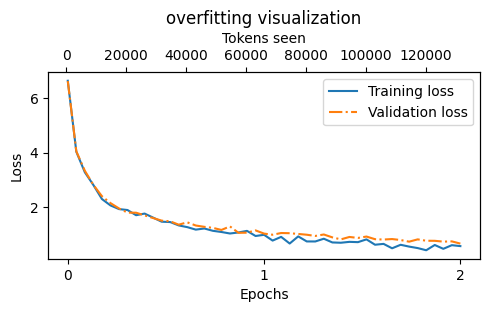

In [11]:
# losses
print(len(train_losses))
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))

myllm.util.plot_learning_losses(num_epochs, token_seen, train_losses, val_losses )

## Extracting responses

In [12]:
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = data.format_instruction_input(entry)
    token_ids = model.generate(
        idx=myllm.util.text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=gpt_config["context_length"],
        eos_id=data.PAD_TOKEN_ID
    )
    generated_text = myllm.util.token_ids_to_text(token_ids, tokenizer)

    response_text = (
        generated_text[len(input_text):].replace("### Response:", "").strip()
    )

    print(input_text)
    print(f"\nCorrect response: \n>> {entry['output']}")
    print(f"\nModel responde: \n>> {response_text.strip()}")
    print(f"-------------------")

Bellow is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response: 
>> The car is as fast as lightning.

Model responde: 
>> 
-------------------
Bellow is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response: 
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model responde: 
>> 
-------------------
Bellow is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response: 
>> Jane Austen.

Model responde: 
>> Name of 'Name of ' Prejudice'.
-------------------
